In [1]:
%matplotlib inline
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows = 200

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=20)



# Loading Dataset

## IOT Devices

The dataset has been extracted at `ROOT_PATH`, containing the data for each IOT device. There are 9 devices in total. There are folders for each IOT device containing `benign_traffic.csv` and further two folders for `gafgyt_attacks` and `mirai_attacks`

## Loading CSVs into Pandas
We will create pandas dataframe for each botnet attack on each IOT device. For each datafram we will combine the attack traffic with the benign traffic add the following column:
- `traffic_type` : benign or attack (0 or 1)


In [3]:
ROOT_PATH = r'/mnt/data/khiz/dataset/00442'

# Train   = B120N10_Baby_Mon  / mirai
train_dev = 'B120N10_Baby_Mon'
train_bot = 'mirai'
# Test    = 737E_Security_Cam / mirai
test_dev  = '737E_Security_Cam'
test_bot  = 'mirai' 

DFS=[]
for dev,bot in [ (train_dev, train_bot), (test_dev, test_bot) ]:
    # Initialize empty df
    df = pd.DataFrame()
    # Load attack csvs
    attack_path = os.path.join(ROOT_PATH, dev, bot+'_attacks')
    attack_files = [ os.path.join(attack_path,f)
                     for f in os.listdir(attack_path)
                        if f.endswith('.csv') ]
    for af in attack_files:
        csv_df = pd.read_csv(af)
        csv_df['traffic_type'] = 'attack'
        df = df.append(csv_df)
    # Load benign csv
    benign_file = os.path.join(ROOT_PATH, dev, 'benign_traffic.csv')
    csv_df = pd.read_csv(benign_file)
    csv_df['traffic_type'] = 'benign'
    df = df.append(csv_df)
    DFS.append(df)

train_df = DFS[0]
test_df  = DFS[1]

In [4]:
train_df.shape

(785954, 116)

In [5]:
test_df.shape

(498164, 116)

In [6]:
train_df['traffic_type'].value_counts()

attack    610714
benign    175240
Name: traffic_type, dtype: int64

In [7]:
test_df['traffic_type'].value_counts()

attack    436010
benign     62154
Name: traffic_type, dtype: int64

<AxesSubplot:title={'center':'Test Traffic'}>

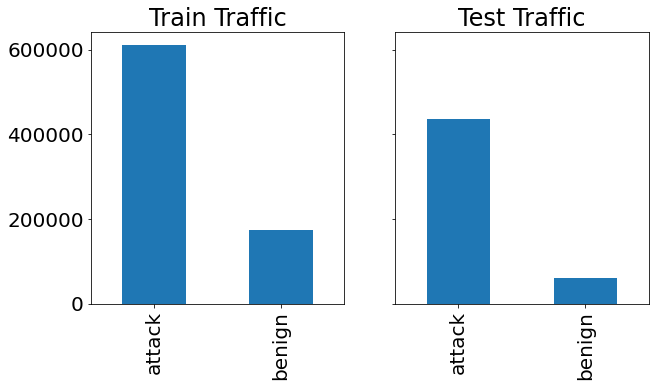

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,5), squeeze=False, sharey=True)
#fig.tight_layout()

train_df['traffic_type'].value_counts().plot(kind='bar', title='Train Traffic', y='count', ax=axes[0,0])
test_df['traffic_type'].value_counts().plot(kind='bar', title='Test Traffic', y='count', ax=axes[0,1])


# Modeling

### Pre processing
Convert the target column `traffic_type` to integer 0 = benigh, 1 = attack 

In [9]:
train_df.loc[ train_df['traffic_type']=='attack', 'traffic_type'] = 1
train_df.loc[ train_df['traffic_type']=='benign', 'traffic_type'] = 0
train_df['traffic_type'] = train_df['traffic_type'].astype(int)

test_df.loc[ test_df['traffic_type']=='attack', 'traffic_type'] = 1
test_df.loc[ test_df['traffic_type']=='benign', 'traffic_type'] = 0
test_df['traffic_type'] = test_df['traffic_type'].astype(int)

### Classifiers and training functions

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [11]:
clf = KNeighborsClassifier()

## Train

In [12]:
X_train = train_df.drop(["traffic_type" ], axis=1)
y_train = train_df["traffic_type"]

X_test = test_df.drop(["traffic_type" ], axis=1)
y_test = test_df["traffic_type"]

clf.fit(X_train, y_train)
#y_preds = clf.predict(X_test)



KNeighborsClassifier()

## Test

In [13]:
y_preds = clf.predict(X_test)


## Evaluate

In [14]:
print(classification_report(y_test, y_preds, output_dict=False))


              precision    recall  f1-score   support

           0       0.47      0.98      0.64     62154
           1       1.00      0.84      0.91    436010

    accuracy                           0.86    498164
   macro avg       0.73      0.91      0.78    498164
weighted avg       0.93      0.86      0.88    498164



In [15]:
confusion_matrix(y_test, y_preds)

array([[ 61078,   1076],
       [ 68450, 367560]])

# Balancing Training DataSet

### Add more benign traffic from other devices

In [16]:
benign_files = [
    os.path.join(ROOT_PATH, 'Danmini_Doorbell', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Ecobee_Thermostat', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Ennio_Doorbell', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '838_Security_Cam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Samsung_Webcam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '1002_Security_Cam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '1003_Security_Cam', 'benign_traffic.csv')


]

for bf in benign_files:
    b_df = pd.read_csv(bf)
    print(b_df.shape)
    b_df['traffic_type'] = 0
    train_df = train_df.append(b_df)

(49548, 115)
(13113, 115)
(39100, 115)
(98514, 115)
(52150, 115)
(46585, 115)
(19528, 115)


<AxesSubplot:title={'center':'Test Traffic'}>

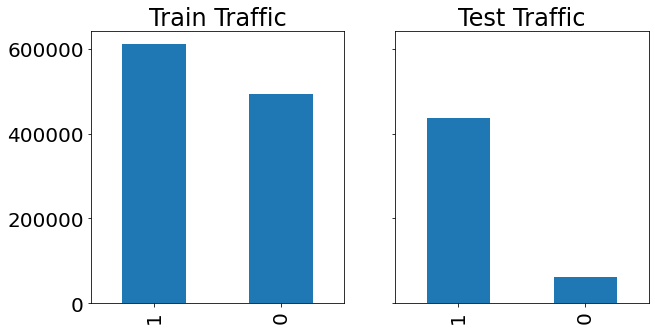

In [17]:
fig, axes = plt.subplots(1,2, figsize=(10,5), squeeze=False, sharey=True)
#fig.tight_layout()

train_df['traffic_type'].value_counts().plot(kind='bar', title='Train Traffic', y='count', ax=axes[0,0])
test_df['traffic_type'].value_counts().plot(kind='bar', title='Test Traffic', y='count', ax=axes[0,1])


In [18]:
train_df['traffic_type'].value_counts()

1    610714
0    493778
Name: traffic_type, dtype: int64

In [19]:
X_train = train_df.drop(["traffic_type" ], axis=1)
y_train = train_df["traffic_type"]

clf2 = KNeighborsClassifier()
clf2.fit(X_train, y_train)


KNeighborsClassifier()

In [20]:
y_preds = clf2.predict(X_test)


In [21]:
print(classification_report(y_test, y_preds, output_dict=False))


              precision    recall  f1-score   support

           0       0.44      0.99      0.60     62154
           1       1.00      0.82      0.90    436010

    accuracy                           0.84    498164
   macro avg       0.72      0.90      0.75    498164
weighted avg       0.93      0.84      0.86    498164



In [22]:
confusion_matrix(y_test, y_preds)

array([[ 61293,    861],
       [ 79362, 356648]])